In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 

%matplotlib inline

Imagine we have a lot of small pieces of images, where we need to assemble them correctly to form a big real image. How do you arrange lots of scrambled image pieces into a big single image? How can you stitch a lot of natural images to a single iamge?

We are looking got specific patterns or specific features which are unique, which can be easily tracked, features which can be easily compared. 

Recognizing features in an image is inherent and easy to humans.

Given an image of a building and 2 patches from the image. Consider the first patch is of a flat surface and the second patch is a corner of a roof on the building. The flat surface is spread in many areas, so it's difficult to find the exact location of the first patch. But the corners of a building are easily found out because at corners wherever you mobe htis patch it will look different. So the second patch can be considered a good feature.

So corners are good features. How do we find them? Look for the regions in an image which maximum variation when moved(by a small amount) in all region around it. Finding these image features is called **Feature Detection**.

Once the features are found, we need to find the same in the other inmages. We take a region around the feature, and search for the same area in other images. We take a region around the feature, we explain it in our own words, like “upper part is blue sky, lower part is building region, on that building there are some glasses etc” and you search for the same area in other images. Basically, you are describing the feature. Similar way, computer also should describe the region around the feature so that it can find it in other images. So called description is called Feature Description. Once you have the features and its description, you can find same features in all images, align them or stitch them.

### Harris Corner Detection

Corners are regions in the image with large vairation in intensity in all the directions. The Harris Corner Detection finds teh difference in intensity for a displacement of (u, v) in all directions.

Window function is either a rectangular window or gaussina window which gives weights to pixels underneath.

We have to maximize this function for corner detection. That means, we have to maximize the second term in the equation. 

E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix}* M *\begin{bmatrix} u \\ v \end{bmatrix}
where

M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\
                                     I_x I_y & I_y I_y \end{bmatrix}

R = det(M) - k(trace(M))^2

So the values of these eigen values decide whether a region is corner, edge or flat.

- When |R| is small, which happens when \lambda_1 and \lambda_2 are small, the region is flat.
- When R<0, which happens when \lambda_1 >> \lambda_2 or vice versa, the region is edge.
- When R is large, which happens when \lambda_1 and \lambda_2 are large and \lambda_1 \sim \lambda_2, the region is a corner.

OpenCV has the function **cv2.cornerHarris()**. Its arguments are :

- img - Input image, it should be grayscale and float32 type.
- blockSize - It is the size of neighbourhood considered for corner detection
- ksize - Aperture parameter of Sobel derivative used.
- k - Harris detector free parameter in the equation.

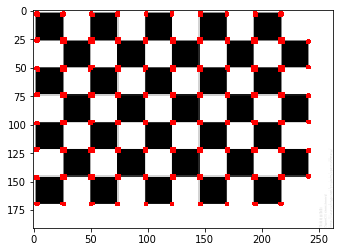

In [4]:
img = cv2.imread('images/chessboard.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

img[dst>0.01 * dst.max()] = [255, 0, 0]

plt.imshow(img)

##### Corner with Subpixel Accuracy

Sometimes, you may need to find the corners with maximum accuracy. OpenCV comes with a function cv2.cornerSubPix() which further refines the corners detected with sub-pixel accuracy. Below is an example. As usual, we need to find the harris corners first. Then we pass the centroids of these corners (There may be a bunch of pixels at a corner, we take their centroid) to refine them. Harris corners are marked in red pixels and refined corners are marked in green pixels. For this function, we have to define the criteria when to stop the iteration. We stop it after a specified number of iteration or a certain accuracy is achieved, whichever occurs first. We also need to define the size of neighbourhood it would search for corners.


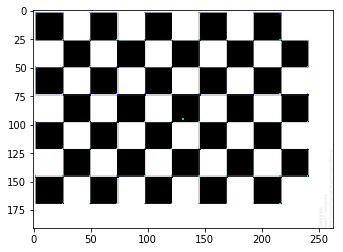

In [2]:
img = cv2.imread('images/chessboard.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst, None)
ret, dst = cv2.threshold(dst, 0.01*dst.max(), 255, 0)
dst = np.uint8(dst)

#find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

plt.imshow(img)

### Shi-Tomasi Corner Detector & Good Features to Track

Scoring function in Shi-Thomasi:

R = min(\lambda_1, \lambda_2)

If it is greater than a trashold value, it is considered as a corner.

**cv2.goodFeatureToTrack()** - It finds N strongest corners in the image by Shi-Tomasi method(Harris Corner Detection can al so be specified). Image should be a grayscale image. Specify number of corners you want to find. Specify quality level between 0-1, which denotes the minimum quality of corner below which everyone is rejected. We also provide minimum euclidean distance between corners detected. 

With this information, the function finds corners in the image. All corners below quality level are rejected. Then it sorts the remaining corners based on quality in descending order. Then function takes first strongest corner, throws away all the nearby corners in the ranage of minimum distance and returns N strongest corners.

In [6]:
img = cv2.imread('images/simple.jpg')
gray = cv2.cvtColor(img, cv2.COLORBGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray, 25, )

(225, 225)